# Exe 1: Subscriptions

### -----------------------------------------------------------------------------------------------------------------------------------------------------------
### -----------------------------------------------------------------------------------------------------------------------------------------------------------
## 1) Problem Modelling

I model the number of renewals of each user $i$ as a random variable $R_i$ taking values in $\{0, 1, ..., T \}$. So, a dataset can be modeled as collection of independent random variables $\{ R_i \}_{i=1}^N$.

We assume that the current event, whether the user renews or not, is independent from all the previous ones. So, the probability distribution of the renewals of $R_i$, given the probability of unsubscribing $p$, is:

\begin{equation}
    \mathbb{P}(R_i = k_i | p) = 
    \begin{cases}
        (1-p)^{k_i}p & if \; 0 \leq k_i < T\\
        1 - S(p,T) & if \; k_i = T
    \end{cases}
\end{equation}

with $S(p,T) = \sum_{k=0}^{T-1} \mathbb{P}(R_i = k | p) $. In other words, I am modelling the user pattern as a sequence of independent Bernoulli variables of probability $p$ up to the time it does not renew. It is a geometric distribution truncated at step $T$.


### 1.1) Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# function to generate the renewals pattern of a single user given T and p (R)
def renewals(T, p):
    renewals = 0
    subscribes = 1
    while renewals < T and subscribes:
        subscribes = np.random.binomial(1, 1-p)
        renewals += subscribes
    return renewals

# function to generate a set of users given T, p, N
def generate_users(N, T, p):
    user_list = []
    for user in range(N):
        user_dict = {
            'user_id': user,
            'renewals': renewals(T, p),
            'T': T
            }
        user_list.append(user_dict)
    return user_list



### 1.2) Simulation

In [2]:
# seed for reproducibility
np.random.seed(1234)  

# parameters of the simulation
N = 100
T = 10
p_simul = 0.75

# generate dataset
user_list = generate_users(N, T, p_simul)

tab = pd.DataFrame(user_list)

print(tab.head())

   user_id  renewals   T
0        0         0  10
1        1         0  10
2        2         0  10
3        3         2  10
4        4         0  10


### -----------------------------------------------------------------------------------------------------------------------------------------------------------
### -----------------------------------------------------------------------------------------------------------------------------------------------------------
## 2) Parameter estimation

Given a set of observations $\mathbf{R} = \{ R_i \}_{i=1}^N$, according to the model discussed before the likelihood of these data given a certain value of $p$ is:

\begin{equation}
    L(p|R) = \prod_{i=1}^N \mathbb{P}(R_i = k_i | p)
\end{equation}

I use as estimator of $p$ the **maximum likelihood estimator** (MLE) $\hat{p}$ that is the value of $p$ such that the observed data are the most probable:

\begin{equation}
    \hat{p} = \underset{p \in [0,1]}{\mathrm{argmax}} \, L(p|R)
\end{equation}

It is not trivial to obtain the expression of $\hat{p}$ in closed form, so we directly estimate it with a grid search over $p \in [0,1]$. To avoid numerical issues due to the vanishing of the likelihood to 0 when dealing with large datasets, I maximize the log-likelihood:

\begin{equation}
    logL(p|R) = log \left( \prod_{i=1}^N \mathbb{P}(R_i = k_i | p) \right) = \sum_{i=1}^N log \left( \mathbb{P}(R_i = k_i | p) \right)
\end{equation}



### 2.1) Functions

In [3]:
# probability distribution of the renewal of a single user
def prob_R(renewals, p, T):
    if renewals < T:
        return ((1-p)**(renewals))*p 
    else:
        probs = [ ((1-p)**(k))*p for k in range(0,T)]
        return np.sum(probs)
    

# likelihood of the observed data
def likelihood(obs_R, p, T):
    prob = 1
    for user in obs_R:
        prob *= prob_R(user['renewals'], p, T)
    return prob

# log-likelihood of the observed data
def log_likelihood(obs_R, p, T):
    log_lik = 0
    for user in obs_R:
        log_lik += np.log(prob_R(user['renewals'], p, T))
    return log_lik

# function finding the maximum likelihood estimator with a grid search
def mle_p(obs_R, T):
    p_grid = np.linspace(0,1, 1000)
    log_lik_p_grid = log_likelihood(obs_R, p_grid, T)
    return p_grid[np.argmax(log_lik_p_grid)], log_lik_p_grid, p_grid

### 2.2) Test

Simul p: 0.75
MLE p: 0.7417


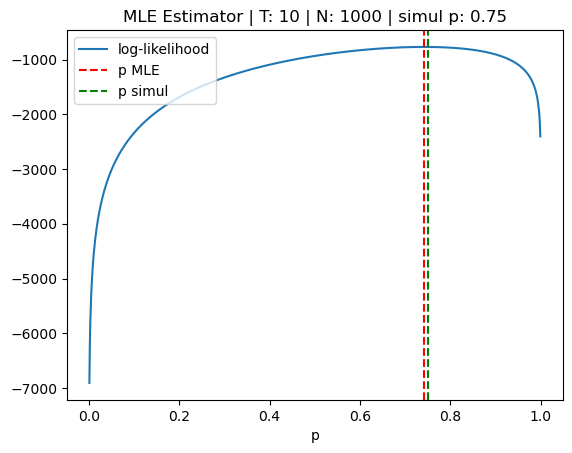

In [4]:
# seed for reproducibility
np.random.seed(1234) 

# simulation parameters
N = 1000
T = 10
p_simul = 0.75

# generate a batch of users
user_list = generate_users(N, T, p_simul)

# estimate p with MLE
p_mle, log_lik_p_grid, p_grid = mle_p(user_list, T)

# plot estimation and log-likelihood
fig, ax = plt.subplots(1,1)
ax.plot(p_grid, log_lik_p_grid, label='log-likelihood')
ax.axvline(x=p_mle, color='red', label='p MLE', linestyle='--')
ax.axvline(x=p_simul, color='green', label='p simul', linestyle='--')
ax.set_title(f'MLE Estimator | T: {T} | N: {N} | simul p: {p_simul}')
ax.set_xlabel('p')
ax.legend(loc='upper left')

# print result
print(f'Simul p: {p_simul}')
print(f'MLE p: {round(p_mle, 4)}')

### 2.3) Simulation and Evaluation

I test performances of the method for different values of $p$, $T$ and $N$. In particular, I focus my attention on the mean absolute error $|p - \hat{p}|$ for different dimensions of the dataset ($N$).

I see that the maximum likelihood estimator increases its precision as the dimension of the dataset increases. Indeed, we observe that:

1. with few data (N = 25, 50), the mean absolute error is larger than 0.05. We imagine this is due to the scarcity of data that makes the estimation imprecise.
3. with many data (N $\geq$ 100) the mean absolute error becomes lower than 0.05.

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:42<00:00,  7.12s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      N  mean_abs_err  mean_abs_err_std
0    25      0.065777          0.064836
1    50      0.053257          0.061264
2   100      0.047207          0.058850
3   250      0.039097          0.058885
4   500      0.036201          0.058287
5  1000      0.034317          0.059486


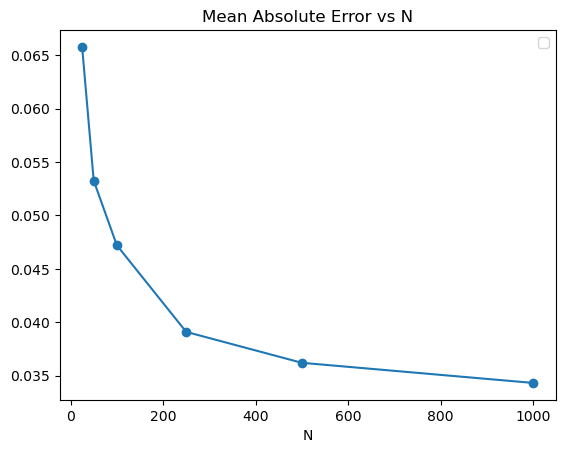

In [5]:
from tqdm import tqdm

p_list = list(np.linspace(0.01, 0.99, 99))
T_list = [5, 10, 15, 20, 25]
N_list = [25, 50, 100, 250, 500, 1000]

error_list = []

np.random.seed(1234)  # seed for reproducibility
for curr_N in tqdm(N_list):
    err_N_list = []
    for curr_p in p_list:
        for curr_T in T_list:
            user_list = generate_users(curr_N, curr_T, curr_p)
            p_mle, _, _ = mle_p(user_list, curr_T)
            err_N_list.append(np.abs(curr_p-p_mle))
    error_list.append({'N': curr_N, 'mean_abs_err': np.mean(err_N_list), 'mean_abs_err_std': np.std(err_N_list)})

tab_err = pd.DataFrame(error_list)
print(tab_err)

# plot error versus N
fig, ax = plt.subplots(1,1)
ax.plot(tab_err['N'], tab_err['mean_abs_err'], ls='-', marker='o')
ax.set_title(f'Mean Absolute Error vs N')
ax.set_xlabel('N')
ax.legend(loc='upper right')

### -----------------------------------------------------------------------------------------------------------------------------------------------------------
### -----------------------------------------------------------------------------------------------------------------------------------------------------------
# 3) Real world data discussion

## 3.1) Estimate $p$ from real data
I try to estimate the value of $p$ of the real world data fitting them with my model.

Original dataset: N = 10000

Maximum Likelihood Estimator from Real Data
Estimation: p = 0.244


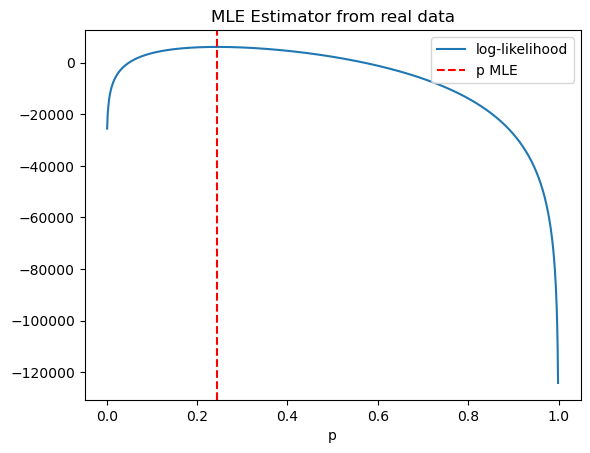

In [6]:
import os

# read data
real_df = pd.read_csv(os.path.join('data', 'data_subscriptions.csv'), index_col=0)
real_df = real_df.sort_values('renewals')

N_real = real_df['N'].sum()
print(f'Original dataset: N = {N_real}')

# convert to int datatype
real_df['renewals'] = real_df['renewals'].apply(int)


# rearrange data in a structure compatible with my algorithm
user_list_real = []

for i in range(21):
    n_curr_ren = real_df[real_df['renewals']==i]['N'].values[0]
    for j in range(n_curr_ren):
        user_dict = {
            'renewals': i,
            'T': 20
            }
        user_list_real.append(user_dict)
        

# estimate p with maximum likelihood estimation
mle_p_real, lik_p_grid, p_grid = mle_p(user_list_real, 20)

# plot likelihood
fig, ax = plt.subplots(1,1)
ax.plot(p_grid, lik_p_grid, label='log-likelihood')
ax.axvline(x=mle_p_real, color='red', label='p MLE', linestyle='--')
ax.set_title(f'MLE Estimator from real data')
ax.set_xlabel('p')
ax.legend(loc='upper right')

print('\nMaximum Likelihood Estimator from Real Data')
print(f'Estimation: p = {round(mle_p_real,3)}')

#### 3.2) Goodness of the model
To assess if the theorical model explains well the phenomenon, I compare the empirical distribution of the renewals of the real dataset with the distribution I obtain with the probabilistic model we have discusses in point 1. In particular, in my data simulator I set $p$ equal to the maximum likelihood estimator ($\hat{p}=0.244$).

I see that the two distibutions are very different, since the one of the real data has a very heavy tail that our model does not show. As a consequence, our model does not look to be able to explain well the phenomenon. I attribute this fact to two reasons:
1. we are modelling users all having the same behaviour (same value of $p$) but it is presumable that, depending on their characteristics, the value of $p$ could change from user to user. We should work in the direction of segmenting the users according to some features so thaat we can attribute to the segments different values of $p$.
2. We are modeling the current action of a user as independent from his/her past actions (i.e. assuming that all the actions are independent). Presumably, for human actions this is not true and the heavy tail of the distribution of the real data could be linked to this fact.

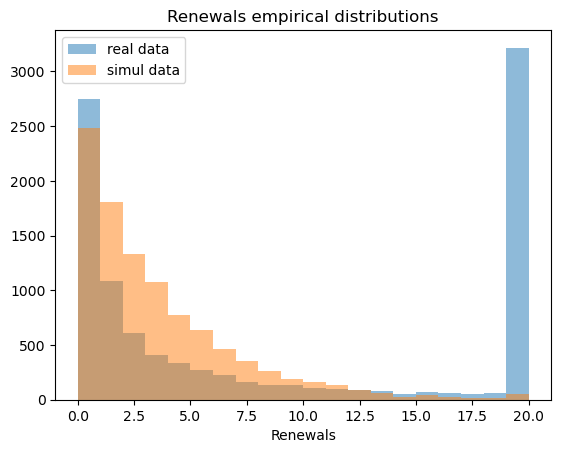

In [7]:
# real data
tab_real = pd.DataFrame(user_list_real)
renewals_real = tab_real['renewals'].values

# simulate data with corresponding N, T and p parameters 
user_list_sim = generate_users(10000, 20, mle_p_real)
tab_sim = pd.DataFrame(user_list_sim)
renewals_sim = tab_sim['renewals'].values

# visualize the two distributions
fig, ax = plt.subplots(1,1)
ax.hist(renewals_real, label='real data', alpha=0.5, bins=20)
ax.hist(renewals_sim, label='simul data', alpha=0.5, bins=20)
ax.set_title('Renewals empirical distributions')
ax.set_xlabel('Renewals')
ax.legend()